In [ ]:
# Shonit Gangoly, Manish Karki, Rohan Mandrekar

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/lgg-mri-segmentation.zip

Archive:  /content/lgg-mri-segmentation.zip
replace kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

# New Section

In [ ]:
train_images = []
mask_images = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_images:
  train_images.append(i.replace('_mask', ''))

print(train_images[:10])
print(mask_images[:10])


['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_52.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_53.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_39.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_48.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_16.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_2.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_17.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_44.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_45.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_26.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830

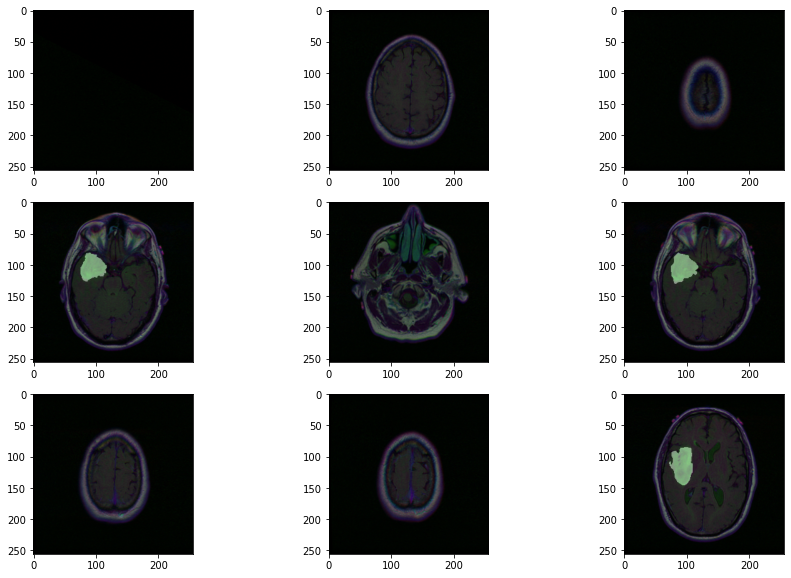

In [ ]:
from matplotlib import image
r,c=3,3
fig=plt.figure(figsize=(15, 10))
for i in range(1,r*c+1):
    fig.add_subplot(r,c,i)
    image_path=train_images[i]
    mask_path=mask_images[i]
    image_val=cv2.imread(image_path)
    image_val=cv2.cvtColor(image_val,cv2.COLOR_BGR2RGB)
    mask_val=cv2.imread(mask_path)
    plt.imshow(image_val)
    plt.imshow(mask_val,alpha=0.4)
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.DataFrame(data={"filename": train_images, 'mask' : mask_images})
data_train, data_test = train_test_split(data,test_size = 0.3)
data_train, data_val = train_test_split(data_train,test_size = 0.3)
print(data_train.values.shape)
print(data_val.values.shape)
print(data_test.values.shape)

(1925, 2)
(825, 2)
(1179, 2)


In [ ]:
image_width = 128
image_height = 128

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K_Back

In [ ]:
# Referred From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(128,128),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
smoothing_val=100

def iou(y_true, y_pred):
    intersection = K_Back.sum(y_true * y_pred)
    sum_ = K_Back.sum(y_true + y_pred)
    jac = (intersection + smoothing_val) / (sum_ - intersection + smoothing_val)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K_Back.flatten(y_true)
    y_predf=K_Back.flatten(y_pred)

    return - iou(y_true, y_pred)

def dc_val(y_true, y_pred):
    y_truef=K_Back.flatten(y_true)
    y_predf=K_Back.flatten(y_pred)
    And=K_Back.sum(y_truef* y_predf)
    return((2* And + smoothing_val) / (K_Back.sum(y_truef) + K_Back.sum(y_predf) + smoothing_val))

def dc_loss_val(y_true, y_pred):
    return -dc_val(y_true, y_pred)





In [ ]:
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
EPOCHS = 80
BATCH_SIZE = 32
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(data_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(image_height, image_width))
    
test_gener = train_generator(data_val, BATCH_SIZE,
                                dict(),
                                target_size=(image_height, image_width))
    
model = unet(input_size=(image_height, image_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dc_loss_val, metrics=["binary_accuracy", iou, dc_val])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(data_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(data_val) / BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 1925 validated image filenames.
Found 1925 validated image filenames.
Epoch 1/80
61/60 [==============================] - ETA: 0s - loss: -0.0935 - binary_accuracy: 0.8691 - iou: 0.0504 - dc_val: 0.0935Found 825 validated image filenames.
Found 825 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02488, saving model to unet_brain_mri_seg.hdf5
60/60 [==============================] - 90s 1s/step - loss: -0.0935 - binary_accuracy: 0.8691 - iou: 0.0504 - dc_val: 0.0935 - val_loss: -0.0249 - val_binary_accuracy: 0.9552 - val_iou: 0.0128 - val_dc_val: 0.0249
Epoch 2/80
61/60 [==============================] - ETA: 0s - loss: -0.1776 - binary_accuracy: 0.9840 - iou: 0.0988 - dc_val: 0.1763
Epoch 2: val_loss did not improve from -0.02488
60/60 [==============================] - 53s 883ms/step - loss: -0.1776 - binary_accuracy: 0.9840 - iou: 0.0988 - dc_val: 0.1763 - val_loss: -0.0237 - val_binary_accuracy: 0.9892 - val_iou: 0.0124 - val_dc_val: 0.0238
Epoch 3/80
61/

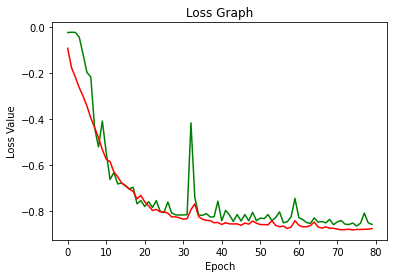

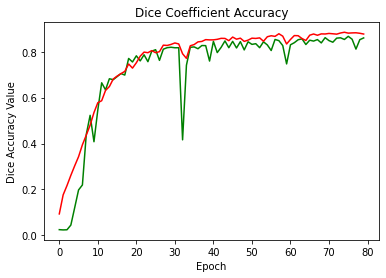

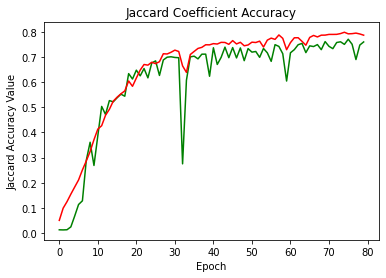

In [ ]:
lst = history.history

train_dice = lst['dc_val']
test_dice = lst['val_dc_val']

train_Jaccard = lst['iou']
test_Jaccard = lst['val_iou']

train_loss = lst['loss']
test_loss = lst['val_loss']

plt.figure(1)
plt.plot(test_loss, 'g-')
plt.plot(train_loss, 'r-')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss Graph", fontsize = 12)


plt.figure(2)
plt.plot(test_dice, 'g-')
plt.plot(train_dice, 'r-')
plt.xlabel("Epoch")
plt.ylabel("Dice Accuracy Value")
plt.title("Dice Coefficient Accuracy", fontsize = 12)


plt.figure(3)
plt.plot(test_Jaccard, 'g-')
plt.plot(train_Jaccard, 'r-')
plt.xlabel("Epoch")
plt.ylabel("Jaccard Accuracy Value")
plt.title("Jaccard Coefficient Accuracy", fontsize = 12)

plt.show()



In [ ]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dc_loss_val': dc_loss_val, 'iou': iou, 'dc_val': dc_val})

In [ ]:
# Testing Images

In [ ]:
test_gen = train_generator(data_test, BATCH_SIZE,
                           dict(), target_size=(image_height, image_width))

results = model.evaluate(test_gen, steps = len(data_test)/BATCH_SIZE)

print("Testing Loss: ", results[0])
print("Testing IOU: ", results[1])
print("Testing Accuracy:", results[2])

Found 1179 validated image filenames.
Found 1179 validated image filenames.
36/36 [==============================] - 16s 427ms/step - loss: -0.8796 - binary_accuracy: 0.9975 - iou: 0.7885 - dc_val: 0.8796
Testing Loss:  -0.8795897960662842
Testing IOU:  0.9975192546844482
Testing Accuracy: 0.7884829044342041


In [ ]:
# Visual representation of our testing

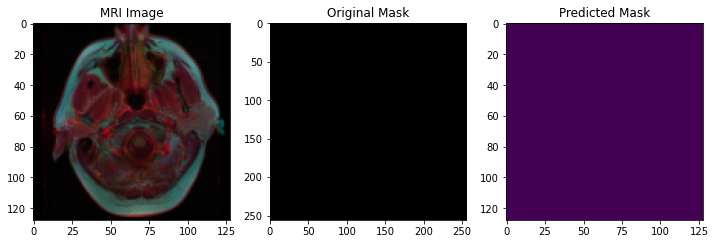

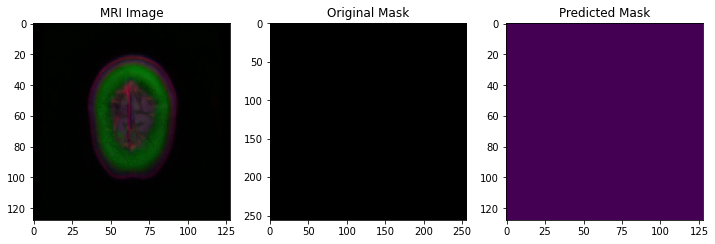

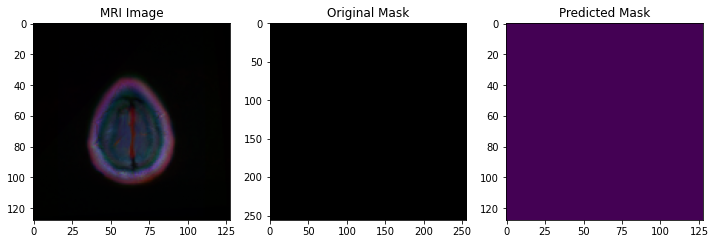

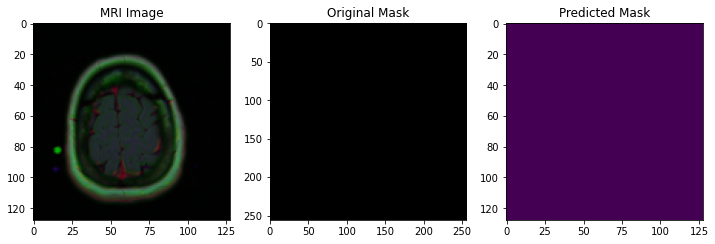

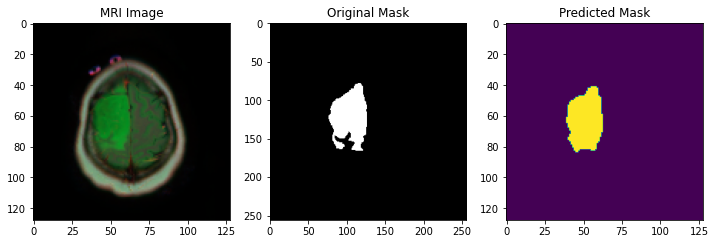

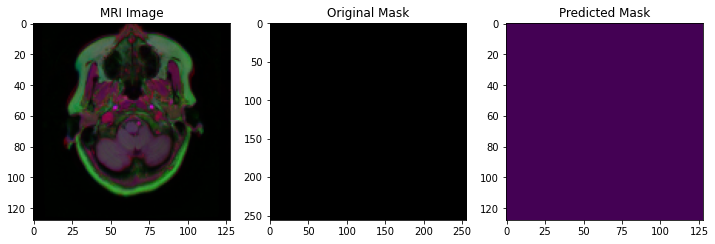

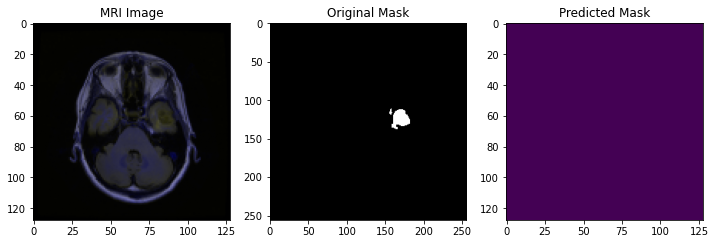

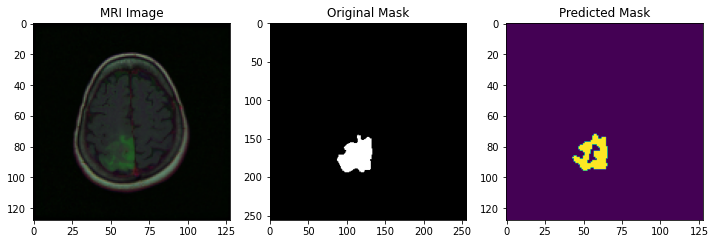

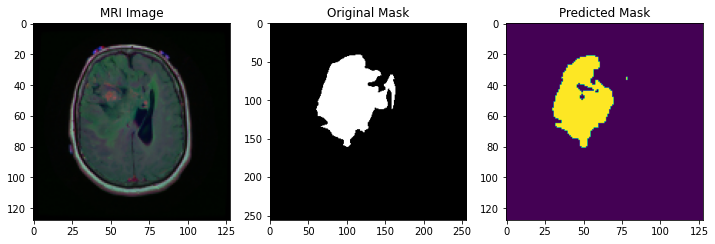

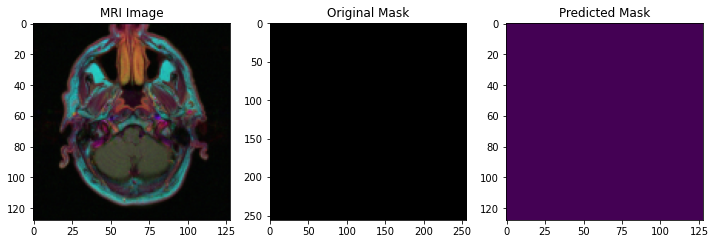

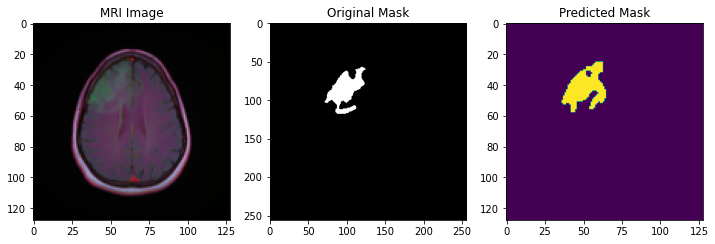

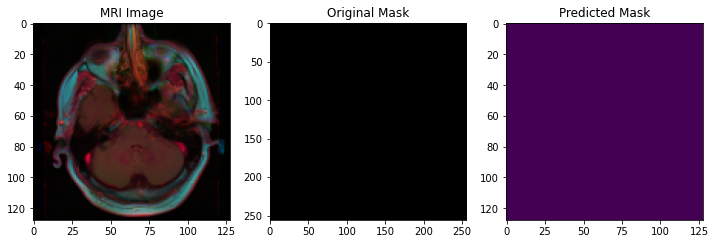

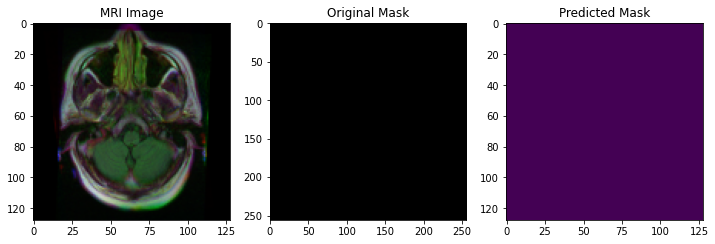

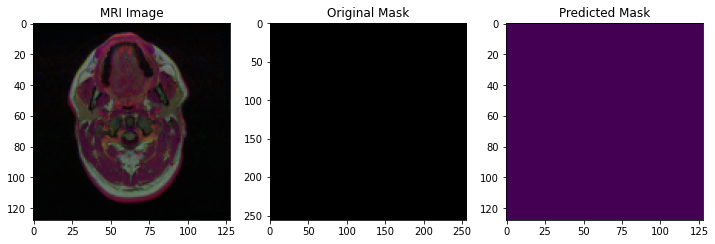

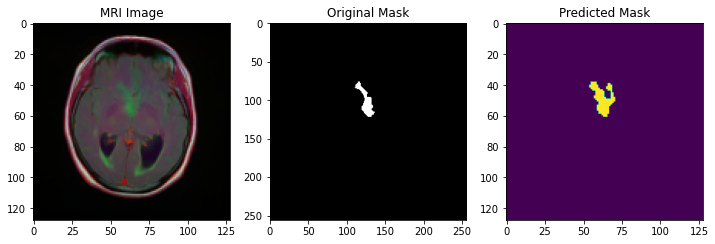

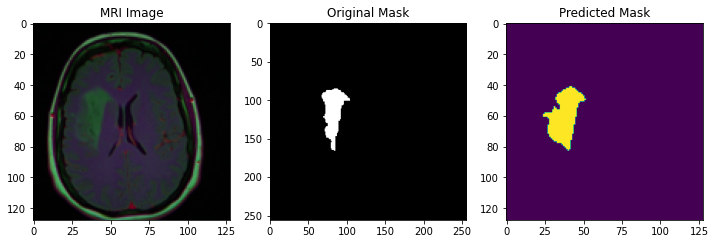

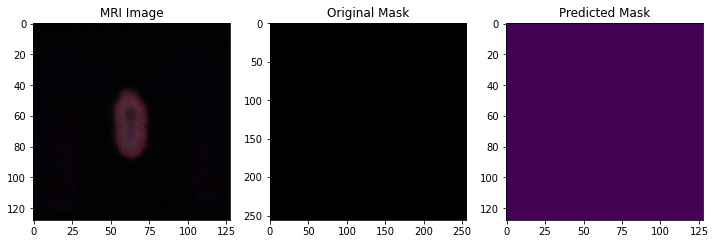

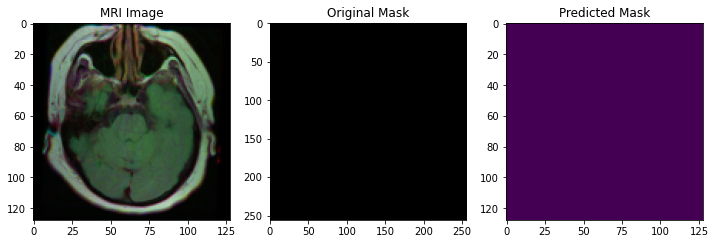

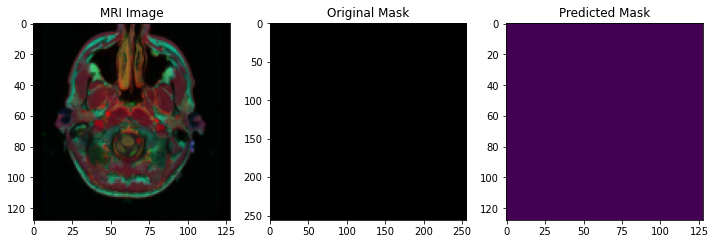

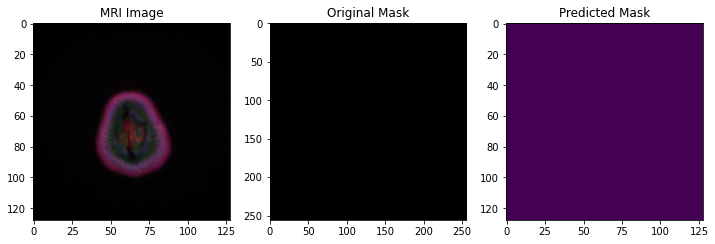

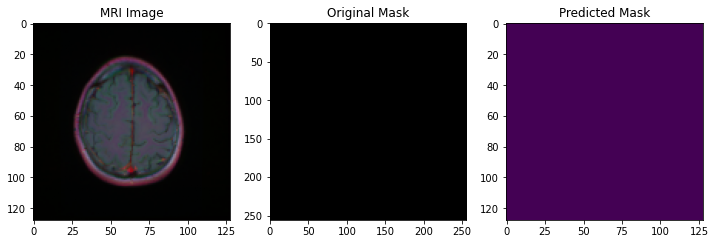

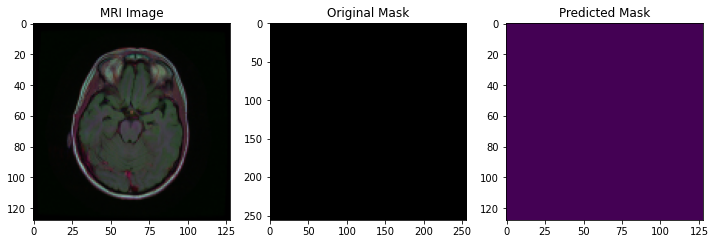

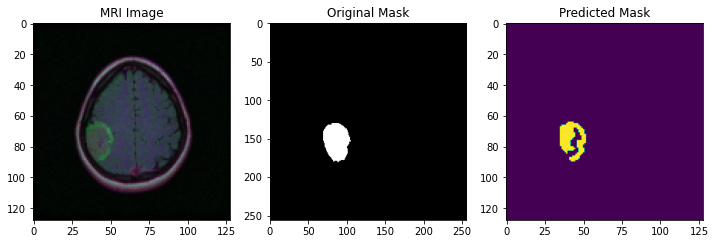

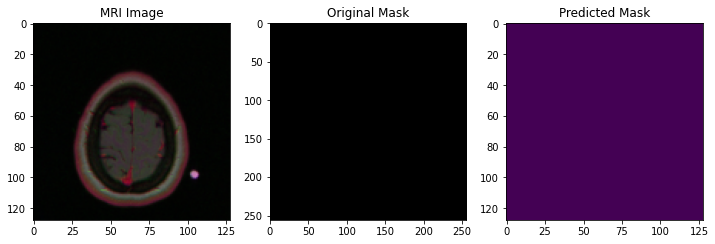

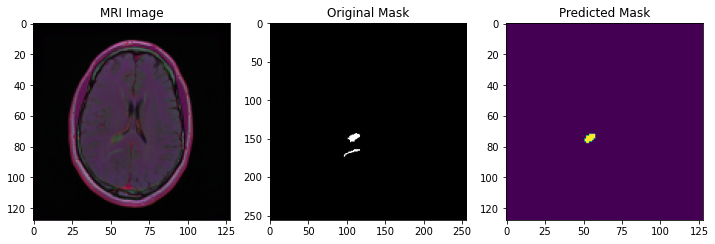

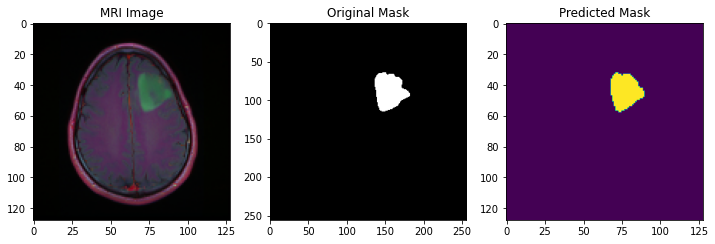

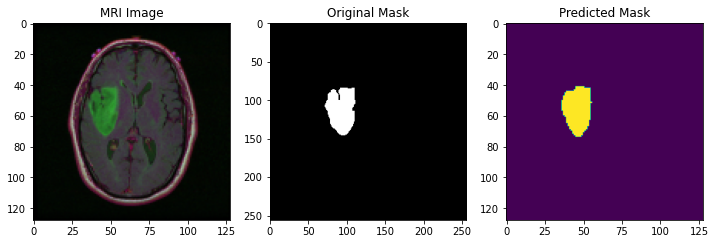

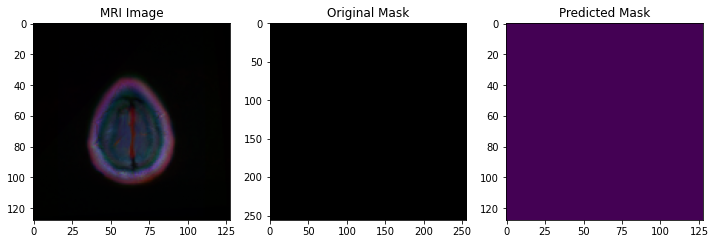

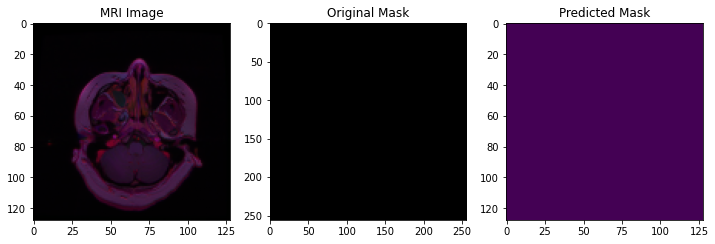

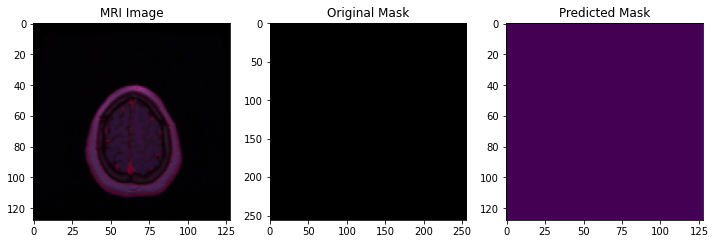

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(data_test.index))
    img = cv2.imread(data_test['filename'].iloc[index])
    img = cv2.resize(img ,(image_height, image_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('MRI Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(data_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Predicted Mask')
    plt.show()